# Setting up a simulation

In this example, I have created a single habitat suitability map with values between zero and one that will serve as BOTH the survival and colonisation control layers. This basically means that in our simulation, the environment affects survival and colonisation to similar degree. Specifiying two different 

It is also important that when loading the raster that we also use the getHeader() function to save the file header. This is important for exporting the virtual species distributions to file after running the simulations.

The header for the file used here is 6 lines in length. This tells the getHeader() function how many lines to read and also how many lines to skip when reading the raster.

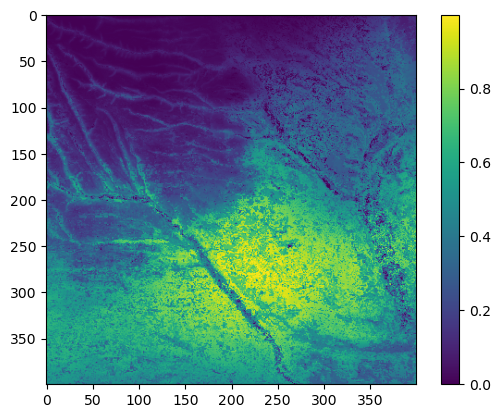

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\Liam\.julia\packages\PyCall\3fwVL\src\numpy.jl:67


PyObject <matplotlib.colorbar.Colorbar object at 0x000000006314DA30>

In [3]:
include("../../src/SpatialVirtualSpecies.jl")
using .SpatialVirtualSpecies
using DataFrames,DelimitedFiles
using PyPlot

header = SpatialVirtualSpecies.getHeader("../../data/suitability_789.asc",6)
suitability = readdlm("../../data/suitability_789.asc",skipstart=6)

imshow(suitability)
colorbar()

### Initialise the state layer (species occurrences)

Now we have our habitat suitability layer, we also need to initialise a state layer. The state layer is separate 2D matrix that can be either a zero or a one. If the state of a cell is set to one, then it is occupied by the virtual species, if it is zero then it is unoccupied.

In this example I have randomly set 1% of cells that have suitability values between 0.4-1.0 as occupied. 

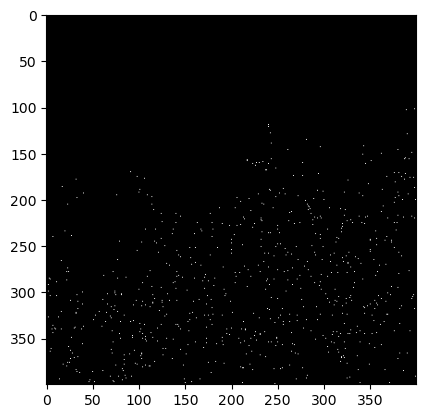

PyObject <matplotlib.image.AxesImage object at 0x000000007FFA5700>

In [4]:
pa = SpatialVirtualSpecies.generateStateLayer(suitability,0.01,(0.4,1.0))
imshow(pa,cmap="gray")

### Define simulation parameters

Next we define a set of parameters for our simulation. To being with, we'll just use the simplest simulation and focus only on dispersal parameters. To do this, we define three parameters that control the mean number of dispersers from a cell, the probability that a cell will be selected for dispersal and the mean dispersal distance (measured in cells units).

To control the behaviour of how cells are selected for colonisation, a position selector (POS) constructor is created. In this example we will use an exponential function but a linear function is available or you can create your own (See XXX). 

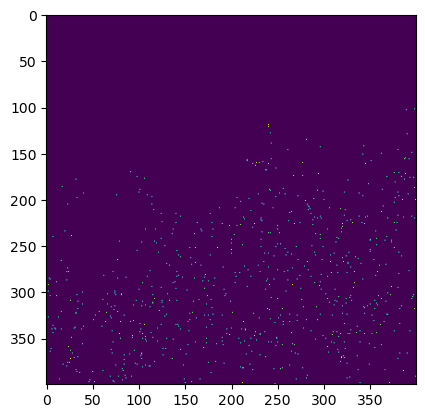

PyObject <matplotlib.image.AxesImage object at 0x00000000979759D0>

In [5]:
paIdx = CartesianIndices(suitability)
# Define POS parameter constructors
pos_params = SpatialVirtualSpecies.ExponentialPosSelector(3)
# Define dispersal parameters
cp = SpatialVirtualSpecies.ColoniseParameters(pos_params,0.2)
#Create simulation constructor
ca = SpatialVirtualSpecies.SpeciesCellularAutomata(pa,paIdx,suitability,suitability)
imshow(ca.pa)

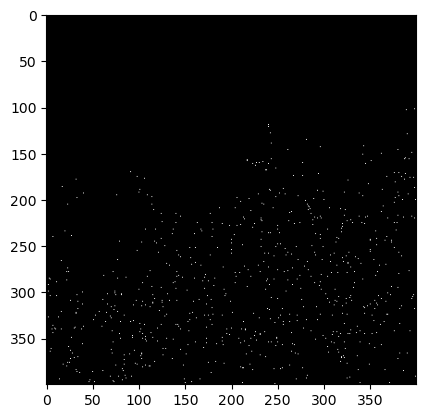

PyObject <matplotlib.image.AxesImage object at 0x00000000979D2D30>

In [8]:
imshow(ca.survivalControl_Passive)
imshow(ca.pa,cmap="gray")

### Create a simulation function

With our parameters set up, we now need to define the simulation behaviour. For this example we will keep things simple and ensure that for each iteration we apply the colonise function and then the extinction function to our state layers.

You can modify the order of these functions or define your own function that modifies the suitability layer (e.g. temporal trends) or the state layer (e.g. disturbances)

In [9]:
function simulate(ca,iterations)
    for i in 1:iterations
        SpatialVirtualSpecies.colonise(ca,cp)
        SpatialVirtualSpecies.extinction(ca)
    end
end  

simulate (generic function with 1 method)

### Run the simulation

Now let's run the simulation for 200 timesteps and see what our virtual species distribution looks like

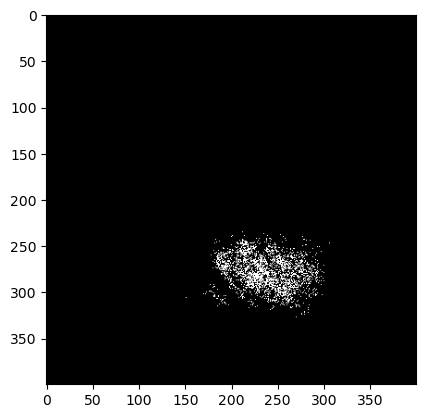

PyObject <matplotlib.image.AxesImage object at 0x0000000099335460>

In [10]:
simulate(ca,200)
imshow(ca.pa,cmap="gray")

### Write the outputs to file

Using the header we pulled out of the raster file at the start, we can then write this back into an ascii file.

In [11]:
open("F:/test_sim.asc","w") do io
    write(io,header)
    writedlm(io,ca.pa)
end